# Model training

This is the jupyter notebook generated from the Edge Impulse website. It contains a couple of helper functions as well as all the code showing the model hyperparameters for training and tuning.

Import the data from Edge Impulse. You can obtain the URL from the Dashboard, right-click on the download icon next to 'Spectral features data' and 'Spectral features labels', and click **Copy link location**.

In [1]:
import numpy as np
import requests

API_KEY = 'my_private_api_key'

X = (requests.get('https://studio.edgeimpulse.com/v1/api/17190/training/28/x', headers={'x-api-key': API_KEY})).content
Y = (requests.get('https://studio.edgeimpulse.com/v1/api/17190/training/28/y', headers={'x-api-key': API_KEY})).content

Store the data in a temporary file, and load it back through Numpy.

In [2]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

ValueError: Cannot load file containing pickled data when allow_pickle=False

Define our labels and split the data up in a test and training set:

In [3]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "noise" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def set_batch_size(batch_size, train_dataset, validation_dataset):
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    validation_dataset = validation_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    return train_dataset, validation_dataset

callbacks = []


TypeError: unsupported operand type(s) for -: 'bytes' and 'int'

Train the model:

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# model architecture
model = Sequential()
model.add(Reshape((1, 200, 3), input_shape=(input_length, )))
model.add(Conv2D(8, kernel_size=(1,9), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1,2), strides=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(16, kernel_size=(1,6), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1,2), strides=2, padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(32, kernel_size=(1,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1,2), strides=2, padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(64, kernel_size=(1,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1,2), strides=2, padding='same'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(16, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dense(classes, activation='softmax', name='y_pred'))

# this controls the learning rate
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset, validation_dataset = set_batch_size(BATCH_SIZE, train_dataset, validation_dataset)
callbacks.append(EarlyStopping(patience=10, restore_best_weights=True))

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(train_dataset, epochs=5000, validation_data=validation_dataset, verbose=2, callbacks=callbacks)


NameError: name 'set_batch_size' is not defined

In [ ]:
# Save the model to disk
model.save('saved_model')

In [7]:
# model architecture
model = Sequential()
model.add(Reshape((1, 200, 3), input_shape=(600, )))
model.add(Conv2D(8, kernel_size=(1,9), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1,2), strides=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(16, kernel_size=(1,6), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1,2), strides=2, padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(32, kernel_size=(1,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1,2), strides=2, padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(64, kernel_size=(1,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1,2), strides=2, padding='same'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(16, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dense(classes, activation='softmax', name='y_pred'))

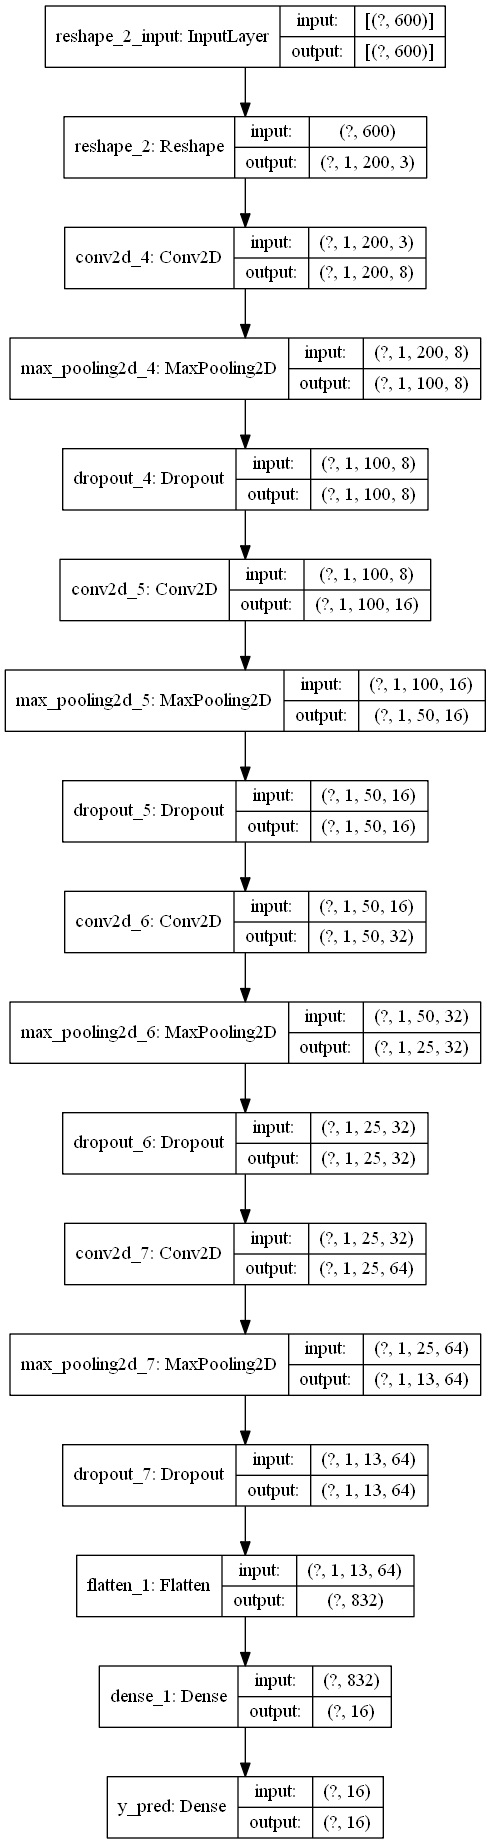

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
from tensorflow.keras.utils import plot_model